In [67]:
%%capture
'''
(C) Copyright 2020-2025 Murilo Marques Marinho (murilomarinho@ieee.org)

     This file is licensed in the terms of the
     Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)
     license.

 Derivative work of:
 https://github.com/dqrobotics/learning-dqrobotics-in-matlab/tree/master/robotic_manipulators
 Contributors to this file:
     Murilo Marques Marinho (murilomarinho@ieee.org)
'''

# DQ8 Optimization-based Robot Control

## Introduction

In the last lesson, you learned the concept of task-space singularities and a particular way to address them.


In this lesson, we will revisit the topic of robot control using quadratic optimiziation formalism.


In [68]:
%%capture
%pip install dqrobotics quadprog
%pip install dqrobotics quadprog --break-system-packages
%pip install dqrobotics-pyplot
%pip install dqrobotics-pyplot --break-system-packages

In [69]:
from math import pi
import numpy as np
from dqrobotics import *
from dqrobotics.utils import DQ_Geometry
from dqrobotics.robot_control import ControlObjective
from dqrobotics.robot_modeling import DQ_Kinematics
from dqrobotics_extensions.pyplot import plot

import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml" # Need to output animation's videos
import matplotlib.animation as anm
from functools import partial # Need to call functions correctly for matplotlib animations

<a name="H_D4ECB91A"></a>
## Notation

Keep these in mind (we will also use this notation when writting papers to conferences and journals):

-  $h\in \mathbb{H}$ : a quaternion. (Bold-face, lowercase character)
-  $\underline{h} \in \mathcal{H}$ : a dual quaternion. (Bold-face, underlined, lowercase character)
-  $p,t,\cdots \in {\mathbb{H}}_p$ : pure quaternions. They represent points, positions, and translations. They are quaternions for which $\textrm{Re}\left(h\right)=0$ .
-  $r\in {\mathbb{S}}^3$ : unit quaternions. They represent orientations and rotations. They are quaternions for which $||h||=1$ .
-  $\underline{x} \in$ $\underline{\mathcal{S}}$ : unit dual quaternions. They represent poses and pose transformations. They are dual quaternions for which $||h||=1$ .
-  $\underline{l} \in {\mathcal{H}}_p \cap$ $\underline{{\mathcal{S}}}$ : a Plücker line.
-  $\underline{{{\pi }}} \in \left\lbrace P\left(\underline{{{\pi }}} \right)\in {\mathbb{H}}_p \right\rbrace \cap \underline{{\mathcal{S}}}$ : a plane.
-  $\theta ,a,b,\cdots \in \mathbb{R}$ : real numbers.
-  ${{q,\cdots }}\in {\mathbb{R}}^n :$ real vectors.
-  $J,A,B,\cdots \in {\mathbb{R}}^{m\times n} :$ real matrices.
<a name="H_C7A69651"></a>
## Robot definition

The concepts of this lesson apply to any manipulator robot. However, to have a more concrete understanding using DQ Robotics, consider the same robot as used in the past lesson.

<p style="text-align:left">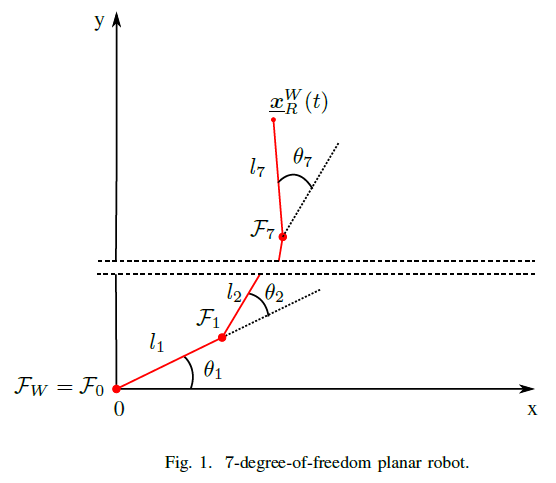</p>


1.  Let the robot $R$ be a 7-DoF planar robot, as drawn in Fig.1.
2. Let ${\mathcal{F}}_W$ be the world-reference frame.
3. Let ${\underline{x} }_R^W (t)\triangleq {\underline{x} }_R$ $\in$ $\underline{\mathcal{S}}$ represent the pose of the *end effector*.
4. Let $R$ be composed of seven rotational joints that rotate about their z-axis, composed in the joint-space vector $q\left(t\right)\triangleq q={\left\lbrack \theta_1 ~\theta_2 ~\theta_3 ~\theta_4 ~\theta_5 ~\theta_6 ~\theta_7 \right\rbrack }^T$ with $\theta_i \left(t\right)\triangleq \theta_i \in \mathbb{R}$ for $i=1,2,\ldots,7$ . The rotation of the reference frames of each joint coincide with the rotation of ${\mathcal{F}}_W$ when $\theta_i =0$ . The length of the joints are $l_i \in$ ${\mathbb{R}}^+ -\lbrace 0\rbrace$ .
5. Consider that we can freely control the joint vector $q$ .

This robot can be modeled by the following class.

In [70]:
from seven_dof_planar_robot_dh import SevenDofPlanarRobotDH
help(SevenDofPlanarRobotDH.kinematics)

Help on function kinematics in module seven_dof_planar_robot_dh:

kinematics()
    Returns the kinematics of the SevenDoFPlanarRobot as DQ_SerialManipulatorDH.



Let us instantiate our robot as follows

In [71]:
seven_dof_planar_robot = SevenDofPlanarRobotDH.kinematics()

## A brief review of quadratic optimization

At some point in your education you might have been introduced to optimization problems. There are many types of optimization problems and in this lesson we will address only two types, which are enough to solve a large class of robot control problems.

### Unconstrained quadratic optimization

The first type is called unconstrained quadratic optimization of type


$$u\in \underset{\dot{q} }{\arg \;\min } ~~~\mathcal{F}\left(\dot{q} \right)$$

where $\mathcal{F}\left(\dot{q} \right)\in {\mathbb{R}}^+$ is a quadratic *objective function* that depends on the current joint configuration. Note that it is called an *optimization problem*, and <u>**NOT**</u> an equation (note that there is no equality sign). In mathematical optimization terminology, $\dot{q}$ is called the *decision variable*.


You can read that as "find all $\dot{q}$ that minimize $\mathcal{F}\left(\dot{q} \right)$ and return one of them as $u$ ". The solution for an unconstrained quadratic optimization problem can, in general, be found analytically. In this lesson we will call that minimizer as $u$ .

### Quadratic programming

The second type of optimization problem that we will address is called quadratic programming (QP), which is a linearly-constrained quadratic optimization problem, in the form


$$\begin{array}{l} u\in \underset{\dot{q} }{\arg \;\min } ~~~\mathcal{F}\left(\dot{q} \right)\\ ~~~~\textrm{subject}\;\textrm{to}~W\dot{q} \preceq w \end{array}$$

where $W\in {\mathbb{R}}^{n\times p}$ and $w\in {\mathbb{R}}^p$ represent $p$ linear constraints related to the $n$ degrees-of-freedom of the robot. Note that we use $\preceq$ and not $\le$ because we are representing element-wise inequalities.


You can read that QP as "find all $\dot{q}$ that minimize $\mathcal{F}\left(\dot{q} \right)$ , subject to $W\dot{q}$ less or equal to $w$ , and return one of them as $u$ ". In general, numerical methods are required to obtain a solution for a QP. Similarly to the unconstrained case, in this lesson we will call that minimizer as $u$ .

## The damped pseudo-inverse as the solution of an unconstrained quadratic optimization problem

In the last lesson, the meaning of the damping factor was introduced in the point-of-view of the SVD of the robot's task Jacobian.


The damping factor can be trivially understood when we re-write the robot control problem in the following way


$$u\in \underset{\dot{q} }{\arg \;\min } ~||J\dot{q} +\eta \tilde{x} ||^2 +\lambda^2 ||\dot{q} ||^2$$

where $J\in {\mathbb{R}}^{m\times n}$ is the task Jacobian for an $n-$ DoF robot and an $m-$ DoF task. In addition, $\eta \in {\mathbb{R}}^+ -\lbrace 0\rbrace$ is the proportional gain of the controller and $\tilde{x} \in {\mathbb{R}}^m$ is the task error. Lastly, $\lambda \in \mathbb{R}$ is the damping factor.


Note that we are balancing two terms in the objective function. The first term, $||J\dot{q} +\eta \tilde{x} ||^2$ , will be high when the task error is high and zero when the task error is zero. The second term, $\lambda^2 ||\dot{q} ||^2$ , will penalize high joint velocities depending on the size of the damping factor. As we saw in practice in the last lesson, the damping factor is used as a term to balance task error convergence and the norm of the joint velocities.


Given that we have an unconstrained quadratic optimization problem which is, by definition, convex, the solution is straightforward. The optimum is where the first-order partial derivative of the objective function with respect to the decision variable equals to zero. Hence

$$\begin{align}
\frac{\partial }{\partial \dot{q} }\left(||J\dot{q} +\eta \tilde{x} ||^2 \right) &= 0 \\
\frac{\partial }{\partial \dot{q} }\left\lbrack (J\dot{q} +\eta \tilde{x} )^T (J\dot{q} +\eta \tilde{x} )\right\rbrack &= 0 \\
\frac{\partial }{\partial \dot{q} }\left({\dot{q} }^T J^T J\dot{q} +2{\dot{q} }^T J^T \tilde{x} +\eta^2 {\tilde{x} }^T \tilde{x} +\lambda^2 {\dot{q} }^T \dot{q} \right) &= 0 \\
2J^T J\dot{q} +2J^T \tilde{x} +2\lambda^2 \dot{q} &= 0 \\
\left(J^T J+\lambda^2 I\right)\dot{q} &= -J^T \tilde{x} \\
\therefore u &\triangleq -{\left(J^T J+\lambda^2 I\right)}^{-1} J^T \tilde{x} \\
\end{align}$$


Notice that this solution is <u>**exacly the same**</u> as the damped pseudo-inverse used in the last lesson.

## Joint limits

Using unconstrained optimization to solve robot-control tasks is useful in some cases, but most tasks in practice have what we call *hard limits*. They are called that way in the sense that those limits are joint-space or task-space limits that cannot be trespassed. For instance, joint limits are a physical type of hard limit. The controller cannot command the robot to move over its joint limits.


When performing kinematic control, the decision variable are the joint velocities and not the joint positions. Therefore, we need to write the joint limits as a linear inequality that depends on the joint velocities.


Suppose that the lower joint limits are $q^- \in {\mathbb{R}}^n$ and the upper joint limits are $q^+ \in {\mathbb{R}}^n$ . The most common way of implementing joint limits using a QP is as follows


$$\begin{array}{l} u\in \underset{\dot{q} }{\arg \;\min } ~~~||J\dot{q} +\eta \tilde{x} ||^2 +\lambda^2 ||\dot{q} ||^2 \\ ~~~~\textrm{subject}\;\textrm{to}~W_{JL} \dot{q} \preceq w_{JL}  \end{array}$$

where


$$W_{JL} =\left\lbrack \begin{array}{c} -I\\ I \end{array}\right\rbrack$$

and


$$w_{JL} =\left\lbrack \begin{array}{c} -\eta_{JL} \left(q^- -q\right)\\ \eta_{JL} \left(q^+ -q\right) \end{array}\right\rbrack .$$

where $\eta_{JL} \in {\mathbb{R}}^+ -\lbrace 0\rbrace$ is a configurable gain. In general, we choose $\eta_{JL} =1$ .


The main idea behind this constraint is to constrain the velocity of the joint in the direction of the joint limit.

### DQ Robotics Example

To solve QPs as described in this lesson using DQ Robotics, use the following class


In [72]:
from dqrobotics.robot_control import DQ_ClassicQPController
help(DQ_ClassicQPController)

Help on class DQ_ClassicQPController in module dqrobotics._dqrobotics._robot_control:

class DQ_ClassicQPController(DQ_QuadraticProgrammingController)
 |  Method resolution order:
 |      DQ_ClassicQPController
 |      DQ_QuadraticProgrammingController
 |      DQ_KinematicConstrainedController
 |      DQ_KinematicController
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: dqrobotics._dqrobotics._robot_control.DQ_ClassicQPController, arg0: dqrobotics._dqrobotics._robot_modeling.DQ_Kinematics, arg1: dqrobotics._dqrobotics._solvers.DQ_QuadraticProgrammingSolver) -> None
 |  
 |  compute_objective_function_linear_component(...)
 |      compute_objective_function_linear_component(self: dqrobotics._dqrobotics._robot_control.DQ_ClassicQPController, arg0: numpy.ndarray[numpy.float64[m, n]], arg1: numpy.ndarray[numpy.float64[m, 1]]) -> numpy.ndarray[numpy.float64[m, 1]]
 |      
 |      Compute the obj


To solve a QP, you have to choose the numerical solver that will be used by the controller. MATLAB has a solver in its optimization toolbox called "quadprog". To use it, first instantiate the robot and the solver


In [73]:
from dqrobotics.solvers import DQ_QuadprogSolver
# Solver definition
qp_solver = DQ_QuadprogSolver()


and then instantiate the controller and set the control objective, the gain, and the damping factor


In [74]:
# Controller definition
translation_controller = DQ_ClassicQPController(seven_dof_planar_robot, qp_solver)
translation_controller.set_control_objective(ControlObjective.Translation)
translation_controller.set_gain(10)
translation_controller.set_damping(1)


Let us define the following joint limits


In [75]:
# Joint limits
q_minus = -(pi/8) * np.ones(7)
q_plus  =  (pi/8) * np.ones(7)

print(f"q_minus = {q_minus}")
print(f"q_plus = {q_plus}")

q_minus = [-0.39269908 -0.39269908 -0.39269908 -0.39269908 -0.39269908 -0.39269908
 -0.39269908]
q_plus = [0.39269908 0.39269908 0.39269908 0.39269908 0.39269908 0.39269908
 0.39269908]



We define the other control-related variables as in the last lesson.


In [76]:
# Desired translation (pure quaternion)
td = 7 * j_
# Sampling time [s]
tau = 0.01
# Simulation time [s]
time_final = 4
# Initial joint values [rad]
q = np.zeros(7)
# Store the joint values
stored_q = []

# Translation controller loop.
for time in np.arange(0, time_final + tau,tau):
    # Store q for posterior animation
    stored_q.append(q)

    # The linear inequalities depend on the current joint values so we calculate them inside the control loop.
    # Define the linear inequality matrix and the linear inequality vector
    Wjl = np.vstack((-np.eye(7), np.eye(7)))
    wjl = np.hstack((-1 * (q_minus-q), 1 * (q_plus-q)))

    # We then add them to the controller using the following method
    # Update the linear inequalities in the controller
    translation_controller.set_inequality_constraint(Wjl, wjl)

    # The rest of the control loop is unchanged with respect to prior lessons.
    # Get the next control signal [rad/s]
    u = translation_controller.compute_setpoint_control_signal(q, vec4(td))

    # Move the robot
    q = q + u * tau

Plot related code with reusable functions `animate_robot` and `setup_plot`.

KeyboardInterrupt: 

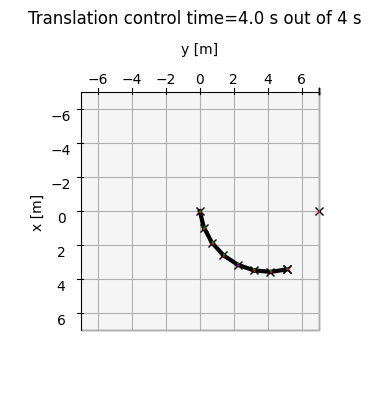

In [77]:
# Animation function
def animate_robot(n, robot, stored_q, xd):
    dof = robot.get_dim_configuration_space()

    plt.cla()
    plot(robot, q=stored_q[n])
    plot(xd)
    plt.xlabel('x [m]')
    plt.xlim([-dof, dof])
    plt.ylabel('y [m]')
    plt.ylim([-dof, dof])
    ax = plt.gca()
    ax.axes.zaxis.set_ticklabels([])
    plt.title(f'Translation control time={time} s out of {time_final} s')

def setup_plot():
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_proj_type('ortho')
    ax.view_init(azim=0, elev=90) #https://stackoverflow.com/questions/33084853/set-matplotlib-view-to-be-normal-to-the-x-y-plane-in-python
    return fig, ax

fig, ax = setup_plot()
anm.FuncAnimation(fig, 
                  partial(animate_robot, robot=seven_dof_planar_robot, stored_q=stored_q, xd = 1 + 0.5*E_*td), 
                  frames=len(stored_q))


We can then verify that the joint limits have been kept.


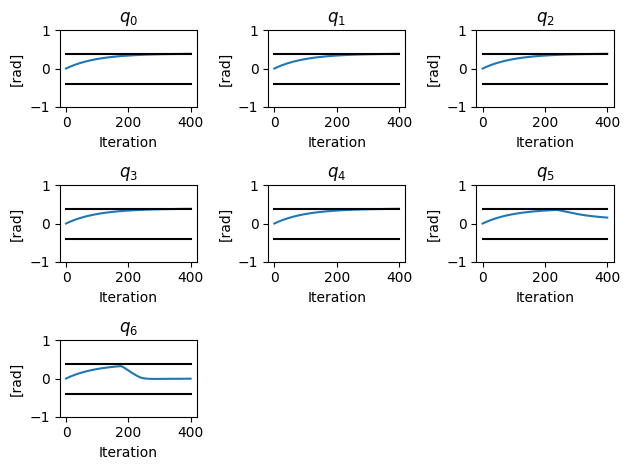

In [ ]:
fig = plt.figure()
for i in range(0, 7):
    plt.subplot(3,3,i+1)
    np_stored_q = np.array(stored_q)
    plt.plot(np_stored_q[:,i])
    plt.plot(np.ones(np_stored_q.shape[0]) * q_minus[i],'k')
    plt.plot(np.ones(np_stored_q.shape[0]) * q_plus[i],'k')
    plt.title(f'$q_{i}$')
    plt.ylim([-1, 1])
    plt.ylabel('[rad]')
    plt.xlabel('Iteration')
fig.tight_layout()


Note that the robot was unable to reach the desired task-space translation due to the joint limits, as shown by the black lines representing the joint limits. This is exactly what we wanted: a controller that will get as close as possible to the target, while maintaning the robot's joint limits.

## Vector-field inequalities: task-space collision avoidance

We have just now seen how to use linear inequalities to prevent the robot from trespassing its joint limits. The joint limits are one of the few applications of joint-space constraints. In most cases, we are interested in having task-space constraints. That is, constraints that are definied at the task space. The difficulty in doing so is writting the task-space constraint as linear constraints in joint space.


An effective way of doing so is called vector-field inequalities (VFIs), presented in detail in the following paper.


[[1]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf) Marinho, M. M; Adorno, B. V; Harada, K.;  and Mitsuishi, M. Dynamic Active Constraints for Surgical Robots using Vector Field Inequalities. *IEEE Transactions on Robotics (T-RO)*, 35(5): 1166–1185. October 2019.


The VFIs are described in detail in [[1]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf), so to simplify the discussion for this lesson, consider the (signed) distance $d\triangleq d\left(q\right)\in \mathbb{R}$ to be the relation between some entity in the robot, such as a point, line, or plane, and another entity in the workspace.

### Keeping the robot entity outside of a restricted zone

Consider the situation of keeping the robot entity outside of a restricted zone. We define the distance error in such way that the distance error is positive whenever the robot is outside of the restricted zone, zero when at the border, and negative when inside the restricted zone. The distance error is then $\tilde{d} \triangleq d-d_{\textrm{safe}}$ , where $d_{\textrm{safe}} \in \mathbb{R}$ is the safe distance, that we suppose to be constant in time in this lesson.


To obtain the general formulation of the VFIs, we start with the following task-space inequality, that will keep our robot outside of a restricted zone


$$\tilde{\dot{d} } \ge -\eta_d \tilde{d} ,$$

where  $\eta_d \in {\mathbb{R}}^+ -\lbrace 0\rbrace$ is a proportional gain. To be used in our QP, we need to re-write this as a joint-space linear constraint, which is what the VFI method does.


The VFIs are then given by


$$\tilde{\dot{d} } =\dot{d} -{\dot{d} }_{\textrm{safe}} =\dot{d} \ge -\eta_d \tilde{d} .$$

Given that the safe distance is constant in time. Now, notice that if the distance depends on the joint values, we can find a distace Jacobian such that the following holds


$$\dot{d} =J_d \dot{q} ,$$

where $J_d \in {\mathbb{R}}^{1\times n}$ is the distance Jacobian for that specific pair of entities.


The linear constraint for that pair of entities, with respect to the joint velocities, then becomes


$$J_d \dot{q} \ge -\eta_d \tilde{d} .$$

That constraint can be re-written to be compatible with our QP definition as


$$-J_d \dot{q} \le \eta_d \tilde{d} .$$

### Keeping the robot entity inside of a safe zone


The reasoning is basically the same of the restricted zone case, but the distance error is redefined as $\tilde{d} \triangleq d_{\textrm{safe}} -d$ . This causes the linear constraint to change to


$$J_d \dot{q} \le \eta_d \tilde{d} .$$

### Square distances instead of distances


Calculating the distance Jacobians of the distance of some primitives introduces algorithmic singularities, as shown in [[2]](https://arxiv.org/pdf/1804.03883).  To handle that problem, we often calculate the Jacobian of the <u>***square***</u> distance instead [[1]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf). The notation for square distances is the upper-case letter $D$ .


[[2]](https://arxiv.org/pdf/1804.03883) Marinho, M. M; Adorno, B. V; Harada, K.;  and Mitsuishi, M. Active Constraints using Vector Field Inequalities for Surgical Robots. In *2018 IEEE International Conference on Robotics and Automation (ICRA)*, pages 5364–5371, May 2018.


### Distance Jacobians

In lesson 4, we learned about distance functions using dual quaternions and in lesson 6 you learned how to calculate a few Jacobians. Using that knowledge, it is easy to calculate the distance Jacobians related to the distance functions.

We will go through how to calculate all the distance Jacobians described in [[1]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf) using DQ Robotics, but we will skip most of the mathematical derivations because they are already described in detail in the paper.

#### Preliminaries

To calculate the distance Jacobian, the following two definitions are useful.


First, the cross product between $a,b\in {\mathbb{H}}_p$ can be mapped into ${\mathbb{R}}^4$ using the operator $\bar{S} \left(.\right)$ , as follows [[1, Eq. (3)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


 ${\textrm{vec}}_4 \left(a\times b\right)=\bar{S} \left(a\right){\textrm{vec}}_4 \left(b\right)=\bar{S} {\left(b\right)}^T {\textrm{vec}}_4 \left(a\right)$ ,


Second, the time derivative of the squared norm of a time-varying quaternion $h\left(t\right)\in {\mathbb{H}}_p$ is given by [[1, Eq. (4)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$$\frac{d}{dt}\left(||h||^2 \right)=\dot{h} h^* +h{\dot{h} }^* =2<\dot{h} ,h>.$$

Two new task Jacobians are also needed. Similarly to how we obtained the translation, rotation, and pose Jacobians, we can also obtain the Jacobians related to lines and planes in the robot.

#### Line Jacobian

Suppose that we want the Jacobian related to line with direction $l_v \in {\mathbb{H}}_p \cap {\mathbb{S}}^3$ that passes through the end-effector. The line will be given by [[1, Eq. (24)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$${<u>l</u> }_v \triangleq {<u>l</u> }_v \left(q\right)=l_v +\varepsilon m_v .$$

Given our definition of line, we have the following [[1, Eq. (28)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$${\textrm{vec}}_8 {\dot{\underline{l} } }_v =J_{l_v } \dot{q}.$$


Using DQ Robotics, we can obtain the line Jacobian as follows


In [ ]:
# Get robot's pose and pose Jacobian
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)

# Define the line direction
lv = k_

# Get the line Jacobian
Jlv = DQ_Kinematics.line_jacobian(Jx, x, lv)

print(f"Jlv = {Jlv}")

Jlv = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.20212828e-18 -1.20212828e-18 -4.14184853e-17  1.40926660e-17
   1.40926660e-17 -2.61236910e-17 -6.63400480e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.45479631e-01 -1.81048005e-01 -8.97954928e-01 -1.29989544e+00
  -1.32780652e+00 -9.77586757e-01 -4.86904393e-01]
 [ 5.67013315e+00  5.29390644e+00  4.59673754e+00  3.68107176e+00
   2.68146135e+00  1.74479379e+00  8.73455272e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]



where $J_{l_r } \in {\mathbb{R}}^{8\times n}$ is the line Jacobian. It can be decomposed into


$$J_{l_v } =\left\lbrack \begin{array}{c} J_{r_v } \\ J_{m_v }  \end{array}\right\rbrack ,$$

where $J_{r_v } \in {\mathbb{R}}^{4\times n}$ is composed of the first four rows of the line Jacobian, which are related to the direction of the line. In addition, $J_{m_v } \in {\mathbb{R}}^{4\times n}$ is composed of the last four rows of the line Jacobian, which are related to the line moment.

<a name="H_801E5F87"></a>
#### Plane Jacobian

Lastly, the Jacobian related to the plane in the end-effector with normal $n_{\pi_v } \in {\mathbb{H}}_p \cap {\mathbb{S}}^3$ will be given by


 ${\textrm{vec}}_8 {\dot{\underline{{{\pi }}} } }_v =J_{\pi_v } \dot{q}$ ,


where


$$J_{\pi_v } =\left\lbrack \begin{array}{c} J_{r_v } \\ J_{d_{\pi_v } }  \end{array}\right\rbrack ,$$

where


$$J_{d_{\pi_v } } ={\textrm{vec}}_4 {\left(n_{\pi_v } \right)}^T J_t +{\textrm{vec}}_4 {\left(t\right)}^T J_{r_v }$$

In [ ]:
# Get robot's pose and pose Jacobian
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)

# Define the line direction
piv = k_

# Get the line Jacobian
Jpiv = DQ_Kinematics.plane_jacobian(Jx, x, piv)

print(f"Jpiv = {Jpiv}")

Jpiv = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.20212828e-18 -1.20212828e-18 -4.14184853e-17  1.40926660e-17
   1.40926660e-17 -2.61236910e-17 -6.63400480e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]


<a name="H_678ECE9D"></a>
#### Point-to-point distance Jacobian
<a name="H_08C30C80"></a>

Let the translation of the robot's point entity be $t\left(q\right)\triangleq t\in {\mathbb{H}}_p$ and the position of a point in the workspace be $p\in {\mathbb{H}}_p$ . The squared-distance between those two point is, as mentioned in lesson 4, is [[1, Eq. (21)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$$D_{t,p} =\left|\right|\mathit{\mathbf{t}}-\mathit{\mathbf{p}}\left|{\left|\right.}^2 \ldotp \right.$$

The derivative of the squared-distance is, therefore [[1, Eq. (22)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$${\dot{\;D} }_{t,p} =2{\textrm{vec}}_4 {\left(\mathit{\mathbf{t}}-\mathit{\mathbf{p}}\right)}^T {\textrm{vec}}_4 \left(\dot{\;\mathit{\mathbf{t}}} \right)\ldotp$$

This means that the point-to-point distance Jacobian is given by


$${\mathit{\mathbf{J}}}_{t,p} =2{\textrm{vec}}_4 {\left(\mathit{\mathbf{t}}-\mathit{\mathbf{p}}\right)}^T {\mathit{\mathbf{J}}}_t \ldotp$$

Using DQ Robotics, it can be calculated as


In [ ]:
# Point in the workspace
p = 2 * j_

# Get robot's pose and pose Jacobian
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)

# Get the robot's translation and translation Jacobian
t = translation(x)
Jt = DQ_Kinematics.translation_jacobian(Jx, x)

# Get the distance Jacobian
Jp_p = DQ_Kinematics.point_to_point_distance_jacobian(Jt, t, p)

print(f"Jp_p = {Jp_p}")

Jp_p = [[ -2.98191852  -9.22193941 -13.44477671 -15.02990676 -13.74440306
   -9.77716359  -4.87629414]]


<a name="H_DDBF00C8"></a>
#### Point-to-line distance Jacobian

Let $\underline{l} \in {\mathcal{H}}_p \cap \underline{{\mathcal{S}}}$ be a line entity in the workspace.  The square distance between a point entity in the robot and that line is [[1, Eq. (29)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$$D_{t,l} =\left|\right|\mathit{\mathbf{t}}\times \mathit{\mathbf{l}}-\mathit{\mathbf{m}}\left|{\left|\right.}^2 \ldotp \right.$$

The point-to-line distance Jacobian is, therefore [[1, Eq. (32)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$${\mathit{\mathbf{J}}}_{t,l} =2{\textrm{vec}}_4 {\left(\mathit{\mathbf{t}}\times \mathit{\mathbf{l}}-\mathit{\mathbf{m}}\right)}^T \bar{\mathit{\mathbf{S}}} {\left(\mathit{\mathbf{l}}\right)}^T {\mathit{\mathbf{J}}}_t \ldotp$$

Using DQ Robotics, it can be calculated as


In [ ]:
# Line in the workspace
l_dq = j_

# Get robot's pose and pose Jacobian
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)

# Get the robot's translation and translation Jacobian
t = translation(x)
Jt = DQ_Kinematics.translation_jacobian(Jx, x)

# Get the distance Jacobian
Jt_l = DQ_Kinematics.point_to_line_distance_jacobian(Jt, t, l_dq)

print(f"Jt_l = {Jt_l}")

Jt_l = [[-8.45393754 -7.89299883 -6.85354842 -5.48832804 -3.99794964 -2.60141647
  -1.30228623]]


<a name="H_20D1E147"></a>
#### Line-to-point distance Jacobian

Let ${\underline{l} }_v \left(q\right)\triangleq {\underline{l} }_v \in {\mathcal{H}}_p \cap \underline{{\mathcal{S}}}$ be a line entity related to the robot.  The square distance between that line and a point in the workspace is given by [[1, Eq. (33)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$$D_{l_v ,p} =\left|\right|\mathit{\mathbf{p}}\times {\mathit{\mathbf{l}}}_v -{\mathit{\mathbf{m}}}_v \left|{\left|\right.}^2 \right.$$

The line-to-point distance Jacobian is a bit more involved, as described in [[1, Eq. (34)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf).


Using DQ Robotics, it can be calculated as


In [ ]:
# Point in the workspace
p = 2 * j_

# Get robot's pose and pose Jacobian
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)

# Get the robot's translation and translation Jacobian
t = translation(x)
Jt = DQ_Kinematics.translation_jacobian(Jx, x)

# Define the direction of the line passing through the end-effector and get
# the line Jacobian
lv = k_
Jl = DQ_Kinematics.line_jacobian(Jx, x, lv)

# Get the robot's rotation
r = rotation(x)
# Get the robot line
lv_dq = Ad(r,lv) + E_*cross(t, Ad(r,lv))

# Get the distance Jacobian
Jlv_p = DQ_Kinematics.line_to_point_distance_jacobian(Jl, lv_dq, p)

print(f"Jlv_p = {Jlv_p}")

Jlv_p = [[ -2.98191852  -9.22193941 -13.44477671 -15.02990676 -13.74440306
   -9.77716359  -4.87629414]]


<a name="H_1E0F3D93"></a>
#### Line-to-line distance Jacobian

Suppose that we want to calculate the Jacobian that relates the distance between a line entity in the robot, ${\underline{l} }_v$ , and a line in the workspace $\underline{l} .$ The mathematical derivation is described in detail in [[1, Eq. (48)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf). To obtain the line-to-line distance Jacobian using DQ Robotics, we do


In [ ]:
# Line in the workspace
l_dq = j_

# Get robot's pose and pose Jacobian
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)

# Get the robot's translation and translation Jacobian
t = translation(x)
Jt = DQ_Kinematics.translation_jacobian(Jx, x)

# Define the direction of the line passing through the end-effector and get
# the line Jacobian
lv_e = k_; # In the point-of-view of the end-effector
Jl = DQ_Kinematics.line_jacobian(Jx, x, lv_e)

# Get the robot's rotation
r = rotation(x)
# Get the robot line direction
lv = Ad(r,lv) #  (in the point-of-view of the base)
lv_dq = lv + E_*cross(t, lv); #  (in the point-of-view of the base)

# Get the distance Jacobian
Jlv_p = DQ_Kinematics.line_to_line_distance_jacobian(Jl, lv_dq, l_dq)

print(f"Jlv_p = {Jlv_p}")

Jlv_p = [[-8.45393754 -7.89299883 -6.85354842 -5.48832804 -3.99794964 -2.60141647
  -1.30228623]]


<a name="H_DA7C4632"></a>
#### Point-to-plane distance Jacobian

Let $\underline{{{\pi }}} \in \left\lbrace P\left(\underline{{{\pi }}} \right)\in {\mathbb{H}}_p \right\rbrace \cap \underline{{\mathcal{S}}}$ be a plane entity in the workspace. The signed distance between the robot's translation, $t$ , and the plane, in the point of view of the plane is given by  [[1, Eq. (57)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf).


$$d_{t,\pi \;}^{\pi \;} =<\mathit{\mathbf{t}},{\mathit{\mathbf{n}}}_{\pi \;} >-d_{\pi \;\;}$$

The point-to-plane distance Jacobian will therefore be given by [[1, Eq. (59)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$$J_{t,\pi } ={\textrm{vec}}_4 {\left(n_{\pi } \right)}^T J_t .$$

Using DQ Robotics, it can be obtained as


In [ ]:
# Define the plane in the workspace
pi_w = i_

# Get robot's pose and pose Jacobian
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)

# Get the robot's translation and translation Jacobian
t = translation(x)
Jt = DQ_Kinematics.translation_jacobian(Jx, x)

# Get the distance Jacobian
Jt_pi = DQ_Kinematics.point_to_plane_distance_jacobian(Jt, t, pi_w)

print(f"Jt_pi = {Jt_pi}")

Jt_pi = [[-5.67013315 -5.29390644 -4.59673754 -3.68107176 -2.68146135 -1.74479379
  -0.87345527]]


<a name="H_757ED165"></a>
#### Plane-to-point distance Jacobian

Let ${\underline{{{\pi }}} }_v \left(q\right)\triangleq {\underline{{{\pi }}} }_v \in \left\lbrace P\left({\underline{{{\pi }}} }_v \right)\in {\mathbb{H}}_p \right\rbrace \cap \underline{{\mathcal{S}}}$ be a plane entity in the robot. The signed distance between the robot's plane entity, ${\underline{{{\pi }}} }_v$ , and a point in the workspace, $p$ , in the point of view of the plane is given by  [[1, Eq. (57)]](https://arxiv.org/ftp/arxiv/papers/1804/1804.11270.pdf)


$$d_{\pi ,p\;}^{\pi \;} =<\mathit{\mathbf{p}},{\mathit{\mathbf{n}}}_{\pi_v \;} >-d_{\pi_{v\ldotp } \;\;}$$

The plane-to-point distance Jacobian will be given by


$$J_{\pi_v ,p} ={\textrm{vec}}_4 {\left(p\right)}^T J_{r_v } -J_{d_{\pi_v } } .$$

Using DQ Robotics, it can be obtained as


In [ ]:
# Point in the workspace
p = 2 * j_

# Get robot's pose and pose Jacobian
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)

# Get the robot's translation and translation Jacobian
t = translation(x)
Jt = DQ_Kinematics.translation_jacobian(Jx, x)

# Get the robot rotation (to calculate the plane)
r = rotation(x)

# Get the robot's plane
n_pi_v_e = i_ # Plane's normal with respect to the end-effector
Jpi = DQ_Kinematics.plane_jacobian(Jx, x, n_pi_v_e)

# Get the distance Jacobian
Jpi_p = DQ_Kinematics.plane_to_point_distance_jacobian(Jpi, p)

print(f"Jpi_p = {Jpi_p}")

Jpi_p = [[-0.97380879  0.0186581   0.98429883  1.78121758  2.29231136  2.44247761
   2.43814707]]


<a name="H_895E4487"></a>
## Vector-field inequalities in action

We saw how to calculate several types of distances and distance Jacobians. Now we need to put this knowledge to good use.

<a name="H_8E230424"></a>
### Preventing collision with walls


Suppose that there is one wall above and one wall below our 7-DoF planar robot and we want to prevent any collisions between the robot and those walls.


The top wall is given by


In [ ]:
pi_top = -j_ - E_ * 2


and the bottom wall is given by


In [ ]:
pi_bottom = j_ + -E_ * 2


Note that the normal of those planes are pointing towards the robot. This is important because it means that the distance of any point of the robot will be positive with respect to those planes. <u>**Mistaking the direction of the planes's normal is a common error, so be careful**</u>.


Let us plot the two walls.


Text(0.5, 0.92, 'Plane constraints')

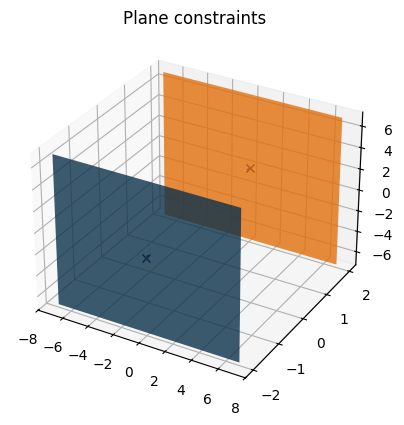

In [78]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plot(pi_top, plane=True, scale=14)
plot(pi_bottom, plane=True, scale=14)
plt.title('Plane constraints')


To prevent the collision between the robot and those walls, one strategy is to create one point-to-plane constraint for each of the robot's joints with respect to those planes. This corresponds to a total of fourteen linear constraints.


Using DQ Robotics, they can be implemented as follows.


In [ ]:
# Define a list of planes
plane_list = [pi_top, pi_bottom]

# Define the robot
seven_dof_planar_robot = SevenDofPlanarRobotDH.kinematics()

# Solver definition
qp_solver = DQ_QuadprogSolver()

# Controller definition
translation_controller = DQ_ClassicQPController(seven_dof_planar_robot, qp_solver)
translation_controller.set_control_objective(ControlObjective.Translation)
translation_controller.set_gain(10)
translation_controller.set_damping(1)

# VFI gain
eta_d = 1

# Desired translation (pure quaternion)
td = 7 * j_
# Sampling time [s]
tau = 0.01
# Simulation time [s]
final_time = 4
# Initial joint values [rad]
q = 0.01 * np.ones(7)

# Translation controller loop.
for time in np.arange(0, time_final + tau,tau):

    # The inequality matrix and vector
    W = None
    w = None
    n = seven_dof_planar_robot.get_dim_configuration_space()

    for joint_counter in range(0, n):

        # Get the pose Jacobian and pose of the current joint
        Jx = seven_dof_planar_robot.pose_jacobian(q, joint_counter)
        x = seven_dof_planar_robot.fkm(q, joint_counter)

        # Get the translation Jacobian and the translation of the current
        # joint
        Jt = DQ_Kinematics.translation_jacobian(Jx, x)
        t = translation(x)

        for plane_counter in range (0, len(plane_list)):

            # Get the current plane
            workspace_plane = plane_list[plane_counter]

            # Calculate the point to plane distance Jacobian
            # We have to augment the Jp_pi with zeros
            Jp_pi = np.hstack((DQ_Kinematics.point_to_plane_distance_jacobian(Jt, t, workspace_plane), np.zeros((1, n-joint_counter-1))))

            # Calculate the point to plane distance
            dp_pi = DQ_Geometry.point_to_plane_distance(t, workspace_plane)

            # Wq <= w
            if W is None:
                W = -Jp_pi
            else:
                W = np.vstack((W, -Jp_pi))
            
            if w is None:
                w = np.array(eta_d * dp_pi)
            else:
                w = np.vstack((w, eta_d * dp_pi))


    # Update the linear inequalities in the controller
    translation_controller.set_inequality_constraint(W, w)

    # Get the next control signal [rad/s]
    u = translation_controller.compute_setpoint_control_signal(q, vec4(td))

    # Move the robot
    q = q + u * tau

    # Plot
    # Plot the robot
    # plot(seven_dof_planar_robot,q);
    # title(['Translation control' ' time = ' num2str(time) 's out of ' num2str(final_time) 's'])
    # Plot the desired pose
    # hold on
    # plot3(td.q(2),td.q(3),td.q(4), 'ko');
    # Plot the walls
    # plot(pi_top, 'plane', 14);
    # plot(pi_bottom, 'plane', 14);
    # hold off
    # [For animations only]
    # drawnow limitrate % [For animations only] Ask MATLAB to draw the plot now

<a name="H_D5D6F4BB"></a>
### Entry-sphere constraint


A very common type of constraint in minimally invasive surgery is the entry-sphere constraint. Suppose there is an incision in the skin of the patient, positioned at


In [ ]:
p = 5 * j_


Let us define the sphere to have a radius of 0.25 m. That is, we choose


In [ ]:
d_safe = 0.25


Moreover, let us attach to our planar robot a 2-meter-long shaft whose axis is collinear with the $x-$ axis of the last link, as follows


In [ ]:
# Define the initial joint configurations [rad]
q = (pi / 8.) * np.ones(7)

# Define the robot
seven_dof_planar_robot = SevenDofPlanarRobotDH.kinematics()

# Add the shaft
seven_dof_planar_robot.set_effector(1 + 0.5 * E_ * (2 * i_))


Let us control the robot to the following desired translation


In [ ]:
# Desired translation
td = -1 * i_ + 4 * j_


In a way that the shaft never goes outside of the entry-sphere. Using DQ Robotics, this can be done as follows


In [ ]:
# Solver definition
qp_solver = DQ_QuadprogSolver()

# Controller definition
translation_controller = DQ_ClassicQPController(seven_dof_planar_robot, qp_solver)
translation_controller.set_control_objective(ControlObjective.Translation)
translation_controller.set_gain(10)
translation_controller.set_damping(1)

# VFI gain
eta_d = 1

# Sampling time [s]
tau = 0.01
# Simulation time [s]
final_time = 4

# Create a new figure
# f = figure(1);
# Translation controller loop.
for time in np.arange(0, time_final + tau,tau):

    # Get the pose Jacobian and the pose
    Jx = seven_dof_planar_robot.pose_jacobian(q)
    x = seven_dof_planar_robot.fkm(q)

    # Get the line Jacobian for the x-axis
    Jl = DQ_Kinematics.line_jacobian(Jx, x, i_)

    # Get the line with respect to the base
    t = translation(x)
    r = rotation(x)
    l = Ad(r, i_)
    l_dq = l + E_ * cross(t, l)

    # Get the line-to-point distance Jacobian
    Jl_p = DQ_Kinematics.line_to_point_distance_jacobian(Jl, l_dq, p)

    # Get the line-to-point square distance
    Dl_p = DQ_Geometry.point_to_line_squared_distance(p, l_dq)

    # Get the distance error
    D_safe = d_safe ** 2
    D_tilde = D_safe - Dl_p

    # The inequality matrix and vector
    W = np.array(Jl_p)
    w = np.array([eta_d * D_tilde])

    # Update the linear inequalities in the controller
    translation_controller.set_inequality_constraint(W, w)

    # Get the next control signal [rad/s]
    u = translation_controller.compute_setpoint_control_signal(q, vec4(td))

    # Move the robot
    q = q + u * tau

    # Clear plot
    # plot(seven_dof_planar_robot, q)
    # clf(f)
    # Plot the robot
    # plot(seven_dof_planar_robot, q)
    # title(['Translation control' ' time = ' num2str(time) 's out of ' num2str(final_time) 's'])
    # hold on
    # Plot the desired pose
    # hold on
    # plot3(td.q(2),td.q(3),td.q(4), 'ko');
    # Plot the shaft in blue
    # t_1 = translation(seven_dof_planar_robot.raw_fkm(q));
    # t_2 = translation(seven_dof_planar_robot.fkm(q));
    # plot3([t_1.q(2) t_2.q(2)],[t_1.q(3) t_2.q(3)],[t_1.q(4) t_2.q(4)],'b','LineWidth',2)
    # Plot the entry sphere
    # plot3(p.q(2), p.q(3), p.q(4), 'ro', 'MarkerSize', 20)
    # [For animations only]
    # drawnow limitrate % [For animations only] Ask MATLAB to draw the plot now

<a name="T_6E209DF5"></a>
# <span style="color:rgb(213,80,0)">Homework</span>

Create a class called `VS050RobotDH` that represents the Denso VS050 robot, whose DH parameters are described in the following table and is composed entirely of revolute joints. (Remember lesson 6)


$$\left\lbrack \begin{array}{cccc} \theta  & d & a & \alpha \\ -\pi  & 0.345 & 0 & \frac{\pi }{2}\\ \frac{\pi }{2} & 0 & 0.25 & 0\\ -\frac{\pi }{2} & 0 & 0.01 & -\frac{\pi }{2}\\ 0 & 0.255 & 0 & \frac{\pi }{2}\\ \pi  & 0 & 0 & \frac{\pi }{2}\\ 0 & 0.07 & 0 & 0 \end{array}\right\rbrack$$

 **End-effector:** attach to the robot a 20cm-long-shaft along the $z-$ axis of the last joint.


 **Initial configuration:** $q(0)={\left\lbrack \begin{array}{cccccc} 0 & \frac{\pi }{3} & \frac{\pi }{3} & 0 & \frac{\pi }{3} & 0 \end{array}\right\rbrack }^T .$


1) Create a file called [vs050_plane_constraints.m] and do the following:

1.  Create a translation controller with $\tau =0.01$ . Choose the other controller parameters so that the control is smooth (see this and prior lessons for examples).
2. Create 6 planes centered around the point $p_1 =0.45\hat{\imath} +0.08\hat{k}$ , so that all normals are pointed inwards, to make a 5cm cube. (remember lesson 4)
3. During control, use point-to-plane VFIs to keep the tooltip always inside the cubic region.
4. Move the end-effector, in order, to the following four desired positions $t_d =\left\lbrace 0.60\hat{\imath} +0.08\hat{k} ,0.20\hat{\imath} +0.15\hat{k} ,0.45\hat{\imath} +0.08\hat{k} ,0.45\hat{\imath} +0.0\hat{k} \right\rbrace$ , for 4 simulation-time seconds each.
5. Plot the task error in one figure
6. Plot the distance of the end-effector to all the six planes using subplots in another figure.

2) Create a file called [vs050_entry_sphere_constraint.m] and do the following:

1.  Create a translation controller with $\tau =0.01$ . Choose the other controller parameters so that the control is smooth (see this and prior lessons for examples).
2. Consider the entry-sphere to be centered at $p_2 =0.45\hat{\imath} +0.2\hat{k}$ . Consider the entry sphere to have a radius of 5 mm.
3. During control, use a line-to-point VFI to keep the shaft always inside the entry-sphere.
4. Move the end-effector, in order, to the following four desired positions $t_d =\left\lbrace 0.45\hat{\imath} +0.03\hat{k} ,0.48\hat{\imath} +0.03\hat{k} ,0.41\hat{\imath} +0.03\hat{k} ,0.40\hat{\imath} +0.01\hat{k} \right\rbrace$ , for 4 simulation-time seconds each.
5. Plot the task error in one figure
6. Plot the distance of the shaft to the center of the entry-sphere in another figure.
